In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [3]:
# 1. Spark Session
# ---------------------------------------
spark = SparkSession.builder \
    .appName("HorseRacingML") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

In [4]:
# 2. Load Data
# ---------------------------------------
df = spark.read.csv(
    "raceform.csv",
    header=True,
    inferSchema=True
)

In [5]:
# 3. Numeric Feature Cleaning
# ---------------------------------------

# Distance: "2m5f" → miles
df = df.withColumn(
    "dist_num",
    when(col("dist").contains("m"),
         split(col("dist"), "m")[0].cast("double") +
         when(split(col("dist"), "m")[1].contains("f"),
              split(split(col("dist"), "m")[1], "f")[0].cast("double") / 8
         ).otherwise(0)
    )
)

In [6]:
# Weight: "11-9" → stones + pounds
df = df.withColumn(
    "wgt_num",
    when(col("wgt").contains("-"),
         split(col("wgt"), "-")[0].cast("double") * 14 +
         split(col("wgt"), "-")[1].cast("double")
    )
)


In [7]:
# Finishing position
df = df.withColumn("pos_num", col("pos").cast("double"))

In [8]:
# Margin of victory
df = df.withColumn("btn_num", col("btn").cast("double"))

In [9]:
# 4. Convert Time to Seconds (NO UDF)
# ---------------------------------------
df = df.withColumn(
    "time_sec",
    when(
        col("time").contains(":"),
        split(col("time"), ":")[0].cast("double") * 60 +
        split(col("time"), ":")[1].cast("double")
    )
)

In [10]:
# 5. Drop Missing Core Values
# ---------------------------------------
df = df.dropna(subset=[
    "dist_num", "wgt_num", "age",
    "time_sec", "btn_num", "pos_num",
    "going", "sex"
])

In [11]:
# 6. Train / Test Split (SAFE)
# ---------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

Train rows: 638069
Test rows: 159266


In [13]:
# 7. Feature Engineering
# ---------------------------------------
numeric_features = ["dist_num", "wgt_num", "age"]
categorical_features = ["going", "sex"]

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="skip"
    )
    for c in categorical_features
]

assembler = VectorAssembler(
    inputCols=numeric_features + [f"{c}_idx" for c in categorical_features],
    outputCol="features",
    handleInvalid="skip"
)

In [14]:
# 8. TASK 1: Predict Finishing Time
# ---------------------------------------
lr_time = LinearRegression(
    featuresCol="features",
    labelCol="time_sec"
)

pipeline_time = Pipeline(stages=indexers + [assembler, lr_time])
time_model = pipeline_time.fit(train_df)
time_preds = time_model.transform(test_df)

eval_rmse = RegressionEvaluator(
    labelCol="time_sec",
    predictionCol="prediction",
    metricName="rmse"
)

eval_r2 = RegressionEvaluator(
    labelCol="time_sec",
    predictionCol="prediction",
    metricName="r2"
)

print("Time Prediction RMSE:", eval_rmse.evaluate(time_preds))
print("Time Prediction R2:", eval_r2.evaluate(time_preds))

Time Prediction RMSE: 18.397991999518645
Time Prediction R2: 0.9613829532199636


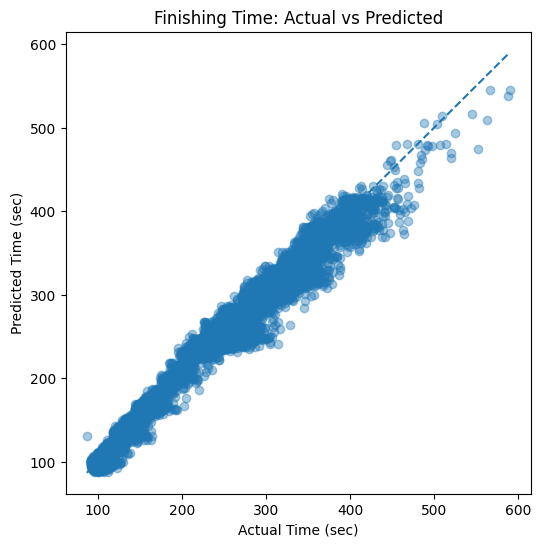

In [19]:
import matplotlib.pyplot as plt

time_pd = time_preds.select(
    "time_sec", "prediction"
).sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(6, 6))
plt.scatter(time_pd["time_sec"], time_pd["prediction"], alpha=0.4)
plt.plot(
    [time_pd["time_sec"].min(), time_pd["time_sec"].max()],
    [time_pd["time_sec"].min(), time_pd["time_sec"].max()],
    linestyle="--"
)
plt.xlabel("Actual Time (sec)")
plt.ylabel("Predicted Time (sec)")
plt.title("Finishing Time: Actual vs Predicted")
plt.show()


In [15]:
# 9. TASK 2: Predict Margin of Victory
# ---------------------------------------
lr_margin = LinearRegression(
    featuresCol="features",
    labelCol="btn_num"
)

pipeline_margin = Pipeline(stages=indexers + [assembler, lr_margin])
margin_model = pipeline_margin.fit(train_df)
margin_preds = margin_model.transform(test_df)

print(
    "Margin RMSE:",
    RegressionEvaluator(
        labelCol="btn_num",
        predictionCol="prediction",
        metricName="rmse"
    ).evaluate(margin_preds)
)

Margin RMSE: 8.383967620755646


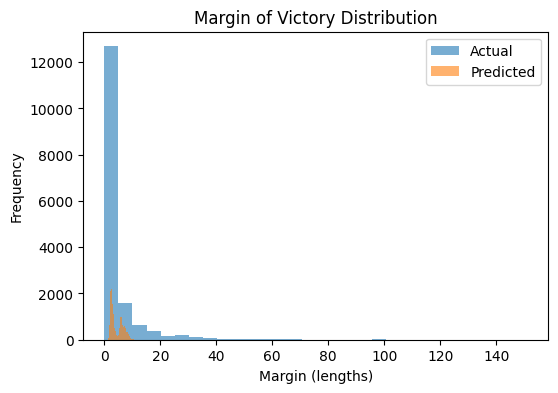

In [20]:
margin_pd = margin_preds.select(
    "btn_num", "prediction"
).sample(0.1, seed=42).toPandas()

plt.figure(figsize=(6, 4))
plt.hist(margin_pd["btn_num"], bins=30, alpha=0.6, label="Actual")
plt.hist(margin_pd["prediction"], bins=30, alpha=0.6, label="Predicted")
plt.xlabel("Margin (lengths)")
plt.ylabel("Frequency")
plt.title("Margin of Victory Distribution")
plt.legend()
plt.show()


In [16]:
# 10. TASK 3: Predict Finishing Position
# ---------------------------------------
dt_pos = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="pos_num",
    maxDepth=6,
    maxBins=64
)

pipeline_pos = Pipeline(stages=indexers + [assembler, dt_pos])
pos_model = pipeline_pos.fit(train_df)
pos_preds = pos_model.transform(test_df)

print(
    "Position RMSE:",
    RegressionEvaluator(
        labelCol="pos_num",
        predictionCol="prediction",
        metricName="rmse"
    ).evaluate(pos_preds)
)

Position RMSE: 3.7097393207781972


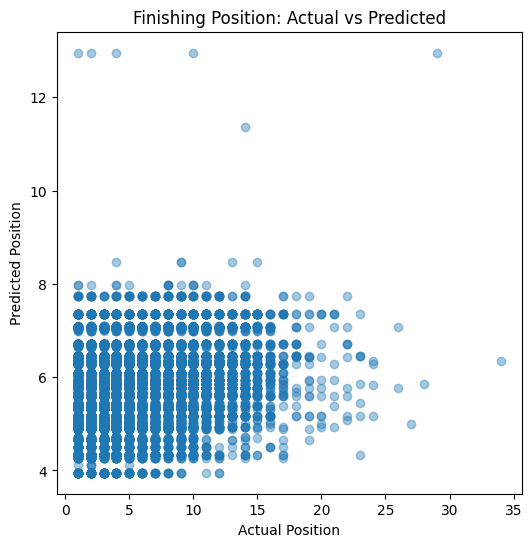

In [21]:
pos_pd = pos_preds.select(
    "pos_num", "prediction"
).sample(0.1, seed=42).toPandas()

plt.figure(figsize=(6, 6))
plt.scatter(pos_pd["pos_num"], pos_pd["prediction"], alpha=0.4)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Finishing Position: Actual vs Predicted")
plt.show()


In [17]:
# 11. Sample Predictions
# ---------------------------------------
pos_preds.select(
    "horse",
    "pos_num",
    "prediction"
).show(10, truncate=False)

+----------------------+-------+------------------+
|horse                 |pos_num|prediction        |
+----------------------+-------+------------------+
|Dark Delight (AUS)    |3.0    |6.280632015800395 |
|Pop Culture (AUS)     |7.0    |6.280632015800395 |
|Real Love (AUS)       |1.0    |7.07673968782331  |
|Bass Strait (NZ)      |14.0   |7.07673968782331  |
|Chester Road (AUS)    |5.0    |6.280632015800395 |
|Starlight Lady (AUS)  |9.0    |7.07673968782331  |
|Quicuyo (GER)         |5.0    |5.1773411179510695|
|Clondaw Kaempfer (IRE)|5.0    |4.92601109157311  |
|Ericht (IRE)          |8.0    |5.386340950879958 |
|Tenor Nivernais (FR)  |5.0    |5.386340950879958 |
+----------------------+-------+------------------+
only showing top 10 rows

